## Introduction

MNIST is the "hello world" of image classification. It is a dataset of handwritten digits taken mostly from United States Census Bureau employees. It is a set of images of digits 0-9, in grayscale and exactly identical dimensions, 28pixels x 28pixels. This serves a relatively simple test for machine learning experiments and evaluating different models.

In this notebook, I explore convolutional neural networks using Keras. Specifically, do techniques such as real time data augmentation and adaptive learn rate improve classification accuracy. While we are likely to see fairly high accuracy, that is not the primary focus here.  

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg
import numpy as np
from numpy import random

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from scipy.interpolate import interp1d, Rbf

def display_images(X, y, rows=5, columns=5, cmap="binary"):
    """ Display images and labels
    """
    fig, ax = plt.subplots(rows,columns, figsize=(6,6))
    for row in range(rows):
        for column in range(columns):
            ax[row][column].imshow(X[(row*columns)+column].reshape(28,28), cmap=cmap)
            ax[row][column].set_title("{}:{}".format("label",np.argmax(y[(row*columns)+column])))
            ax[row][column].set_axis_off()
    fig.tight_layout()

%matplotlib inline

Using TensorFlow backend.


## Load and prepare data
Our data looks like this. It is a csv file with the true classification in the ```label``` column, followed by 784 pixel values (28x28 pixels unrolled). Each pixel takes a value ranging from 0-255. Since these are black and white images, each pixel is represented by a single value (channel) instead of three separate R, G, B values (3 channels) in a color image. 

In [3]:
#df = pd.read_csv("../input/train.csv")
df = pd.read_csv("train.csv")
df.sample(1)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
4711,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We randomly split this set of 42000 images into 3 sets - 
- training: data used to train convnet
- cross validation: data used to validate performance
- test: data used to test classification accuracy

While there is a separate test set available, we are not using that in this notebook, since it is not labeled and cannot be easily evaluated.


In [4]:
X_train, X_val, y_train, y_val = train_test_split(df.iloc[:,1:].values, df.iloc[:,0].values, test_size = 0.4)
X_cv, X_test, y_cv, y_test = train_test_split(X_val, y_val, test_size = 0.5)
print("X_train:{}\ny_train:{}\n\nX_cv:{}\ny_cv:{}\n\nX_test:{}\ny_test:{}".format(X_train.shape, y_train.shape, X_cv.shape, y_cv.shape, X_test.shape, y_test.shape))

X_train:(25200, 784)
y_train:(25200,)

X_cv:(8400, 784)
y_cv:(8400,)

X_test:(8400, 784)
y_test:(8400,)


The data is in an unrolled format, i.e. each sample is a sequence of 784 pixel values. We will convert this using numpy's reshape function to (28x28x1). i.e. an image that is 28 pixels wide and 28 pixels tall, with 1 channel (black and white image).  So for example, the shape of the training set becomes (25200 samples, 28px, 28px, 1ch)

We change the output class (label) to categorical or one hot format. i.e. instead of a single value 0-9, we convert this to a array of size 10. e.g.
y = [9] becomes
y = [0,0,0,0,0,0,0,0,1,0]

Additionally, we scale all the features (pixel values) from a range of 0-255, to a range of 0-1. This is done by dividing each value in the feature matrix by 255.

Here are the new shapes of training, cross validation and test data sets.

In [5]:
width = 28
height = 28
channels = 1
X_train = X_train.reshape(X_train.shape[0], width, height, channels)
X_cv = X_cv.reshape(X_cv.shape[0], width, height, channels)
X_test = X_test.reshape(X_test.shape[0], width, height, channels)

# convert output classes to one hot representation
y_train = np_utils.to_categorical(y_train, num_classes=10)
y_cv = np_utils.to_categorical(y_cv, num_classes=10)
y_test = np_utils.to_categorical(y_test, num_classes=10)

X_train = X_train.astype('float32')
X_cv = X_cv.astype('float32')
X_test = X_test.astype('float32')

# Scale features (pixel values) from 0-255, to 0-1 
X_train /= 255
X_cv /= 255
X_test /= 255
print("Reshaped:")
print("X_train:{}\ny_train:{}\n\nX_cv:{}\ny_cv:{}\n\nX_test:{}\ny_test:{}".format(X_train.shape, y_train.shape, X_cv.shape, y_cv.shape, X_test.shape, y_test.shape))

Reshaped:
X_train:(25200, 28, 28, 1)
y_train:(25200, 10)

X_cv:(8400, 28, 28, 1)
y_cv:(8400, 10)

X_test:(8400, 28, 28, 1)
y_test:(8400, 10)


Here is a preview of a few images in the training set.

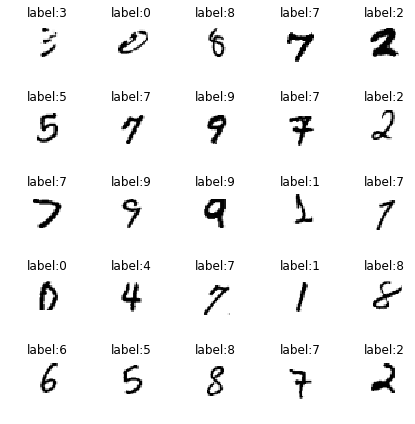

In [6]:
display_images(X_train, y_train)

In [35]:
batch_size=16
epochs=15

def small_cnn_model():
    m = Sequential()
    m.add(Conv2D(32, (5, 5), activation='relu', input_shape=(width, height, channels) ))
    m.add(MaxPooling2D(pool_size=(3,3)))
    m.add(Flatten())
    m.add(Dense(128, activation='relu'))
    m.add(Dropout(0.4))
    m.add(Dense(10, activation='softmax'))
    m.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return m

def deep_cnn_model():
    m = Sequential()
    m.add(Conv2D(32, (5, 5), activation='relu', input_shape=(width, height, channels) ))
    m.add(Conv2D(32, (5,5)))
    m.add(MaxPooling2D(pool_size=(2,2)))
    m.add(Dropout(0.2))
    m.add(Conv2D(64, (3,3)))
    m.add(Conv2D(64, (3,3)))
    m.add(MaxPooling2D(pool_size=(2,2)))
    m.add(Dropout(0.2))
    m.add(Flatten())
    m.add(Dense(1024, activation='relu'))
    m.add(Dropout(0.4))
    m.add(Dense(10, activation='softmax'))
    m.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return m

def plot_metrics(h, title=""):
    """ Plot training metrics - loss and accuracy, for each epoch, 
        given a training history object
    """
    fig, axes = plt.subplots(1,2, figsize=(10,5))
      
    axes[0].plot(h.history['loss'], color="steelblue", label="Training", lw=2.0)
    axes[0].plot(h.history['val_loss'], color="orchid", label="Validation", lw=2.0)

    axes[0].set_title("{} (Loss)".format(title))
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")

    axes[1].plot(h.history['acc'], color="steelblue", label="Training", lw=2.0)
    axes[1].plot(h.history['val_acc'], color="orchid", label="Validation", lw=2.0)
    
    axes[1].set_title("{} (Accuracy)".format(title))
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")

    for axis in axes:
        axis.ticklabel_format(useOffset=False)
        axis.spines["top"].set_visible(False)
        axis.spines["right"].set_visible(False)
        axis.legend(loc='best', shadow=False)
    fig.tight_layout()

## Training a small convnet
Here we train a very small convnet with 1 convolutional layer and 2 dense layers.

<img src="https://raw.githubusercontent.com/vinayshanbhag/keras-cnn-mnist/master/sm.png"/>

In [58]:
sm = small_cnn_model()
#sm.summary()
metrics_small = sm.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_cv,y_cv), verbose = 2, shuffle=True)
sm.save_weights("small.h5")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
flatten_18 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_32 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 10)                1290      
Total params: 264,394
Trainable params: 264,394
Non-trainable params: 0
_________________________________________________________________
Trai

Plot training and validation metrics across epochs.

import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
from keras.utils import plot_model
plot_model(sm, show_shapes=True, show_layer_names=False,to_file='sm.png')

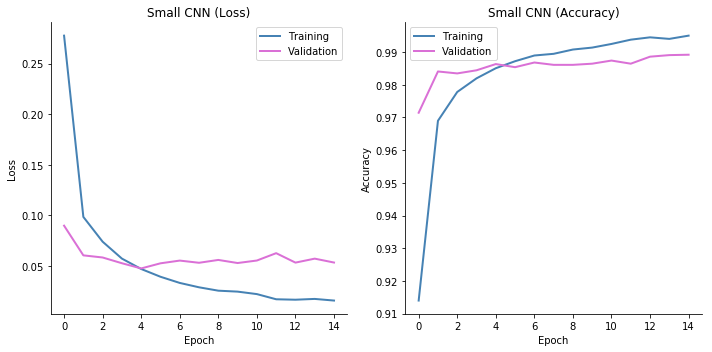

In [59]:
plot_metrics(metrics_simple,"Small CNN")

## Training a deep convnet
Here we train a deep convnet with 4 convolutional layers and 2 dense layers.

<img src="https://raw.githubusercontent.com/vinayshanbhag/keras-cnn-mnist/master/dm.png"/>

In [60]:
dm = deep_cnn_model()
#dm.summary()
metrics_deep = dm.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_cv, y_cv), verbose = 2, shuffle=True)
#plot_model(dm, show_shapes=True, show_layer_names=False,to_file='dm.png')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 20, 20, 32)        25632     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 10, 10, 32)        0         
_________________________________________________________________
dropout_33 (Dropout)         (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 8, 8, 64)          18496     
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 6, 6, 64)          36928     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 3, 3, 64)          0         
__________

Plot training and validation metrics across epochs.

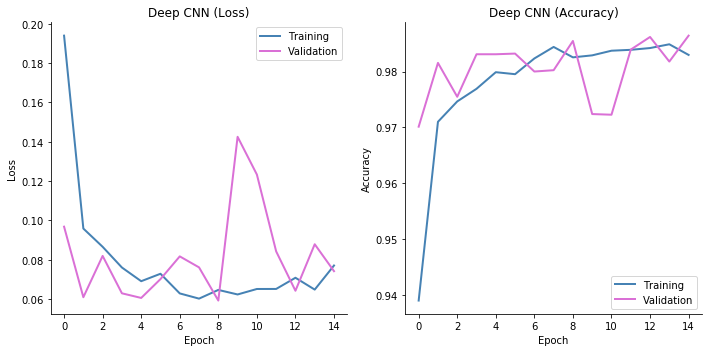

In [61]:
dm.save_weights("deep.h5")
plot_metrics(metrics_deep,"Deep CNN")

## Adaptive Learning Rate
Learning rate is the step size in gradient descent. Our convnet is trying to find the lowest point, the point at which the loss is minimum. If the step size is too large, it may not converge or take too long. On the other hand, if the step size is too small, it may converge on a local minimum.
<p>&nbsp;</p>
<sup style="float: left;">Source: Wikimedia Commons, the free media repository</sup>
<img style="float: left;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/1e/Extrema_example.svg/300px-Extrema_example.svg.png"/>
<p style="float: left;">We will use ```ReduceLROnPlateau``` to adapt the learning rate based on results from each epoch. For instance, if the validation accuracy doesn't improve in 2 subsequent epochs (patience), then reduce the learning rate by half (factor).  See [```ReduceLROnPlateau```](https://keras.io/callbacks/#reducelronplateau) for more options.</p>

<p style="float: left">Further, the verbose mode, allows us to see when this happens.</p>

In [62]:
lrc = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=2, factor=0.5, cooldown=2, epsilon=0.00001)

## Training a small convnet with adaptive learning rate
Here we train the same small convnet we used earlier, but with adaptive learning rate. 

In [63]:
smlrc = small_cnn_model()
metrics_small_lrc = smlrc.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_cv, y_cv), verbose = 2, shuffle=True, callbacks=[lrc])
smlrc.save_weights("small_lrc.h5")

Train on 25200 samples, validate on 8400 samples
Epoch 1/15
7s - loss: 0.2996 - acc: 0.9089 - val_loss: 0.0809 - val_acc: 0.9757
Epoch 2/15
7s - loss: 0.1099 - acc: 0.9668 - val_loss: 0.0609 - val_acc: 0.9805
Epoch 3/15
7s - loss: 0.0752 - acc: 0.9769 - val_loss: 0.0503 - val_acc: 0.9855
Epoch 4/15
6s - loss: 0.0605 - acc: 0.9815 - val_loss: 0.0478 - val_acc: 0.9861
Epoch 5/15
6s - loss: 0.0510 - acc: 0.9839 - val_loss: 0.0446 - val_acc: 0.9868
Epoch 6/15
6s - loss: 0.0439 - acc: 0.9858 - val_loss: 0.0446 - val_acc: 0.9864
Epoch 7/15
6s - loss: 0.0360 - acc: 0.9876 - val_loss: 0.0470 - val_acc: 0.9862
Epoch 8/15
6s - loss: 0.0317 - acc: 0.9903 - val_loss: 0.0457 - val_acc: 0.9882
Epoch 9/15
6s - loss: 0.0296 - acc: 0.9903 - val_loss: 0.0533 - val_acc: 0.9870
Epoch 10/15
6s - loss: 0.0250 - acc: 0.9920 - val_loss: 0.0571 - val_acc: 0.9881
Epoch 11/15

Epoch 00010: reducing learning rate to 0.0005000000237487257.
7s - loss: 0.0234 - acc: 0.9921 - val_loss: 0.0504 - val_acc: 0.9881
Epoch 

Plot training and validation metrics across epochs.

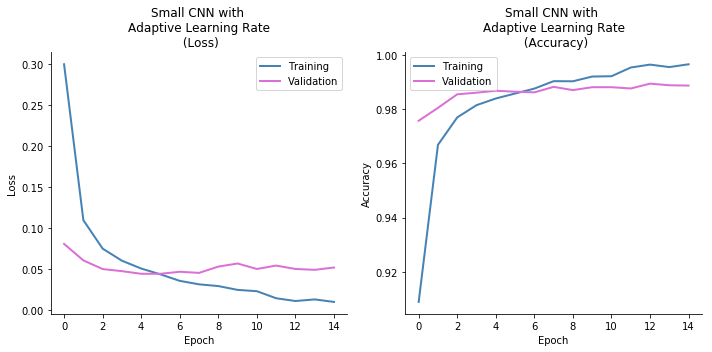

In [66]:
plot_metrics(metrics_small_lrc, "Small CNN with \nAdaptive Learning Rate\n")

## Training a deep convnet with adaptive learning rate
Here we train the same deep convnet we used earlier, but with adaptive learning rate. 

In [65]:
dmlrc = deep_cnn_model()
metrics_deep_lrc = dmlrc.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_cv, y_cv), verbose = 2, shuffle=True, callbacks=[lrc])
dmlrc.save_weights("deep_lrc.h5")

Train on 25200 samples, validate on 8400 samples
Epoch 1/15
10s - loss: 0.2055 - acc: 0.9343 - val_loss: 0.0877 - val_acc: 0.9723
Epoch 2/15
9s - loss: 0.1034 - acc: 0.9678 - val_loss: 0.0875 - val_acc: 0.9720
Epoch 3/15
9s - loss: 0.0814 - acc: 0.9766 - val_loss: 0.0499 - val_acc: 0.9840
Epoch 4/15
9s - loss: 0.0861 - acc: 0.9746 - val_loss: 0.0883 - val_acc: 0.9750
Epoch 5/15
9s - loss: 0.0710 - acc: 0.9789 - val_loss: 0.0533 - val_acc: 0.9861
Epoch 6/15
9s - loss: 0.0765 - acc: 0.9777 - val_loss: 0.0789 - val_acc: 0.9826
Epoch 7/15
9s - loss: 0.0652 - acc: 0.9827 - val_loss: 0.0917 - val_acc: 0.9825
Epoch 8/15
9s - loss: 0.0679 - acc: 0.9806 - val_loss: 0.0644 - val_acc: 0.9864
Epoch 9/15
9s - loss: 0.0675 - acc: 0.9821 - val_loss: 0.0720 - val_acc: 0.9836
Epoch 10/15
9s - loss: 0.0630 - acc: 0.9834 - val_loss: 0.0962 - val_acc: 0.9788
Epoch 11/15

Epoch 00010: reducing learning rate to 0.0005000000237487257.
9s - loss: 0.0630 - acc: 0.9835 - val_loss: 0.0844 - val_acc: 0.9839
Epoch

Plot training and validation metrics across epochs.

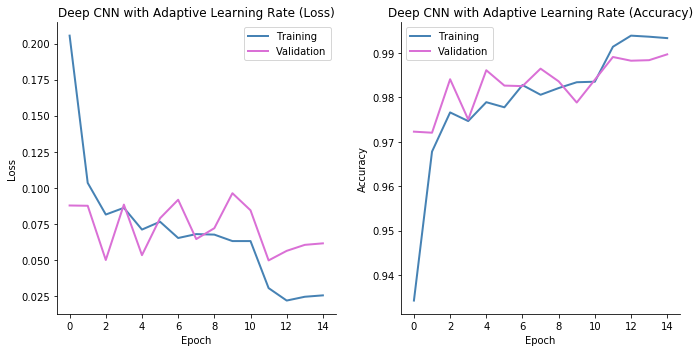

In [67]:
plot_metrics(metrics_deep_lrc, "Deep CNN with Adaptive Learning Rate")

## Data Augmentation
To improve classification accuracy, we can augment the training samples, with random transformations of images in the training set. In Keras, this is done using ```keras.preprocessing.image.ImageDataGenerator``` class. We can apply random transformations such as, zooming, rotation, shifting the image up/down. We will limit rotation to a few degrees, and disable horizontal and vertical flipping, as our dataset of digits is prone to produce ambiguous results with these operations. 

See [```ImageDataGenerator```](https://keras.io/preprocessing/image/#imagedatagenerator) for lots of other options that are useful for other types of images.

In [68]:
idg = ImageDataGenerator(
        rotation_range=15,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False, data_format="channels_last")

Here are a few images produced by the image data generator.

Sample images from ImageDataGenerator:


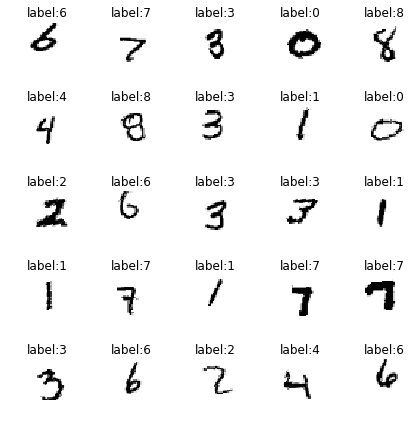

In [69]:
image_data = idg.flow(X_train,y_train, batch_size=25).next()
print("Sample images from ImageDataGenerator:")
display_images(image_data[0], image_data[1])

## Training a small convnet with data augmentation
Here we train the same small convnet we used earlier, but with data augmentation. 

In [ ]:
smalrc = small_cnn_model()
metrics_small_lrc_augmented = smalrc.fit_generator(idg.flow(X_train,y_train, batch_size=batch_size),
                    epochs = epochs,
                    steps_per_epoch=X_train.shape[0]/10,
                    validation_data=(X_cv,y_cv),
                    callbacks=[lrc],
                    verbose = 2)
smalrc.save_weights("small_lrc_augmented.h5")

Epoch 1/15
10s - loss: 0.4864 - acc: 0.8442 - val_loss: 0.0756 - val_acc: 0.9770
Epoch 2/15
10s - loss: 0.2238 - acc: 0.9306 - val_loss: 0.0550 - val_acc: 0.9846
Epoch 3/15


Plot training and validation metrics across epochs.

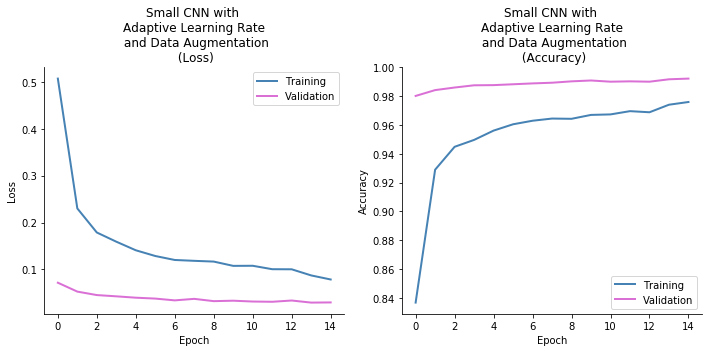

In [53]:
plot_metrics(metrics_small_lrc_augmented, "Small CNN with \nAdaptive Learning Rate\n and Data Augmentation\n")

## Training a deep convnet with data augmentation
Here we train the same deep convnet we used earlier, but with data augmentation. 

In [55]:
dmalrc = deep_cnn_model()
metrics_deep_lrc_augmented = dmalrc.fit_generator(idg.flow(X_train,y_train, batch_size=batch_size),
                    epochs = epochs,
                    steps_per_epoch=X_train.shape[0]/10,
                    validation_data=(X_cv,y_cv),
                    callbacks=[lrc],                         
                    verbose = 2)
dmalrc.save_weights("deep_lrc_augmented.h5")

Epoch 1/15
15s - loss: 0.3461 - acc: 0.8899 - val_loss: 0.0897 - val_acc: 0.9757
Epoch 2/15
15s - loss: 0.1760 - acc: 0.9470 - val_loss: 0.0779 - val_acc: 0.9774
Epoch 3/15
15s - loss: 0.1674 - acc: 0.9512 - val_loss: 0.0477 - val_acc: 0.9867
Epoch 4/15
15s - loss: 0.1557 - acc: 0.9526 - val_loss: 0.0433 - val_acc: 0.9869
Epoch 5/15
15s - loss: 0.1540 - acc: 0.9568 - val_loss: 0.0537 - val_acc: 0.9844
Epoch 6/15
15s - loss: 0.1543 - acc: 0.9561 - val_loss: 0.0501 - val_acc: 0.9870
Epoch 7/15
15s - loss: 0.1506 - acc: 0.9579 - val_loss: 0.0577 - val_acc: 0.9840
Epoch 8/15
15s - loss: 0.1539 - acc: 0.9566 - val_loss: 0.0687 - val_acc: 0.9833
Epoch 9/15
15s - loss: 0.1476 - acc: 0.9569 - val_loss: 0.0447 - val_acc: 0.9896
Epoch 10/15
15s - loss: 0.1580 - acc: 0.9558 - val_loss: 0.0443 - val_acc: 0.9886
Epoch 11/15
15s - loss: 0.1587 - acc: 0.9562 - val_loss: 0.0490 - val_acc: 0.9880
Epoch 12/15

Epoch 00011: reducing learning rate to 0.0005000000237487257.
15s - loss: 0.1580 - acc: 0.9585

Plot training and validation metrics across epochs.

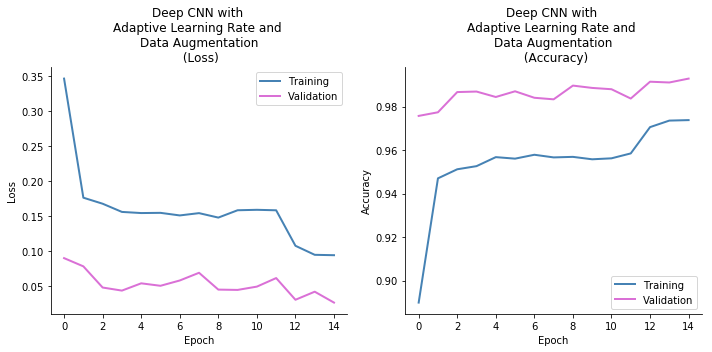

In [56]:
plot_metrics(metrics_deep_lrc_augmented,"Deep CNN with \nAdaptive Learning Rate and \nData Augmentation\n")

## Validation Accuracy
How did the various models do in terms of accuracy?

In [57]:
metrics = [metrics_small, metrics_small_lrc, metrics_small_lrc_augmented, metrics_deep, metrics_deep_lrc, metrics_deep_lrc_augmented]
models = ["Small CNN", "Small CNN with Adaptive Learning Rate", "Small CNN with Adaptive Learning Rate and data augmentation",
          "Deep CNN", "Deep CNN with Adaptive Learning Rate", "Deep CNN with Adaptive Learning Rate and data augmentation",
         ]
data = []
for i, m in enumerate(zip(models, metrics)):
    data.append([m[0], "{:0.2f}".format(m[1].history["val_acc"][-1]*100)])

results = pd.DataFrame(data, columns=("Model","Validation Accuracy"))
from IPython.display import display, HTML
display(HTML(results.to_html(index=False)))

NameError: name 'metrics_small' is not defined

## Classification Report
How did the best models perform on the test set?

In [26]:
print(classification_report(y_test.argmax(axis=1), smalrc.predict(X_test).argmax(axis=1)))

             precision    recall  f1-score   support

          0       1.00      0.99      0.99       829
          1       1.00      0.99      0.99       939
          2       0.99      0.99      0.99       823
          3       1.00      0.99      0.99       898
          4       0.99      0.99      0.99       831
          5       0.99      0.99      0.99       776
          6       0.99      1.00      0.99       823
          7       0.98      0.99      0.99       813
          8       0.98      0.99      0.98       783
          9       0.99      0.99      0.99       885

avg / total       0.99      0.99      0.99      8400



In [27]:
print(classification_report(y_test.argmax(axis=1), dmalrc.predict(X_test).argmax(axis=1)))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       829
          1       1.00      0.99      1.00       939
          2       1.00      0.99      1.00       823
          3       1.00      0.99      1.00       898
          4       1.00      0.99      1.00       831
          5       1.00      0.99      0.99       776
          6       0.99      1.00      0.99       823
          7       0.98      1.00      0.99       813
          8       0.99      0.99      0.99       783
          9       0.99      0.99      0.99       885

avg / total       0.99      0.99      0.99      8400

